In [1]:
import contextlib
import ipynb.fs
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import torch
import wave

from collections import defaultdict
from scipy.io import wavfile
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn import tree
from tqdm import tqdm

from .defs.formant_vowel_prediction import vowel_prediction, vowel_prediction_sd
from .defs.vowel_feedback_function import vowel_feedback
from .defs.extract_formant import extract_formant

random_state=42

In [2]:
folder = '../../allwavs/allvowl/extracted'
files = os.listdir(folder)

In [3]:
def trim_wav(in_wav, out_wav, start, end):
    sample_rate, wave_data = wavfile.read(in_wav)
    start_sample = int(start * sample_rate)
    end_sample = int(end * sample_rate)
    wavfile.write(out_wav, sample_rate, wave_data[start_sample:end_sample])

for file in tqdm(files):
    if file == 'trimmed':
        continue
    start, end = file.split('__')[2:4]
    start = float(start)
    end = float(end)
    trim_wav(folder + '/' + file, folder + '/trimmed/' + file, start, end)

 48%|██████████████████████████████████████████████████▉                                                      | 852/1757 [00:17<00:18, 47.73it/s]


ValueError: not enough values to unpack (expected 2, got 0)

In [4]:
v_files = os.listdir(folder + '/trimmed')
cnt = 0
n_formants = 4

vowels = defaultdict(list)

for file in tqdm(v_files):
    if file == 'img':
        continue
    path = folder + '/trimmed/' + file
    with contextlib.closing(wave.open(path, 'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    try:
        formants = extract_formant(path, start_time=0, end_time=duration, f0min=math.ceil(3/duration + 0.000001), n_formants=n_formants)
        vowel, gender, start, end, phonemes, word, orig_file = file.split('__')
        vowel = vowel.replace('E+', 'E').replace('@', '9')
        if len(phonemes) == 1:
            phonemes = '_'.join(list(word.replace('1', ''))).replace('u', 'y')
        elif len(phonemes) == 2:
            phonemes = 't_E+'
        elif len(phonemes) == 3 and '_' not in phonemes:
            phonemes = 't_U~+'
        vowels[vowel].append([*formants, gender, phonemes.split('_')[0]])
        #print(vowel, gender, phonemes, word, *formants)
    except ZeroDivisionError:
        cnt += 1
        continue
        
print(cnt)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1756/1756 [00:50<00:00, 34.54it/s]

401


In [7]:
fs = [defaultdict(list) for i in range(n_formants)]
for key, val in vowels.items():
    for formants in val:
        for i in range(n_formants):
            fs[i][key].append(formants[i])

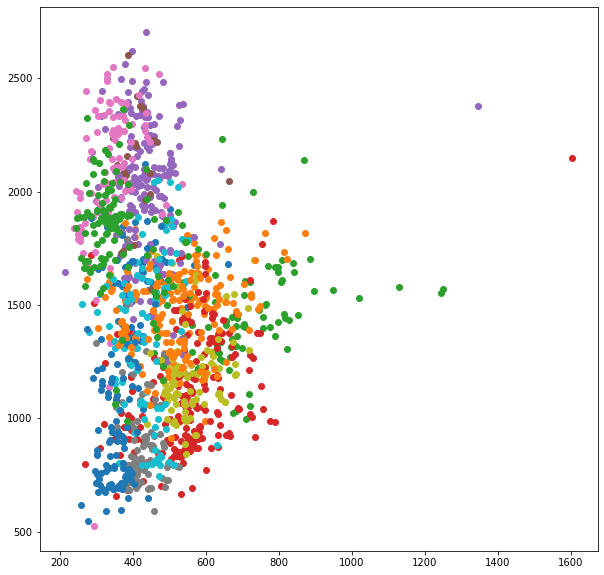

In [10]:
plt.figure(figsize=(10, 10))
for key in fs[0]:
    plt.scatter(fs[0][key], fs[1][key])
plt.show()

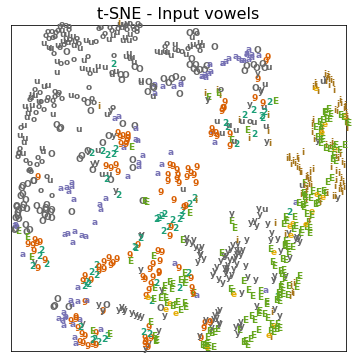

In [11]:
key2idx = {key: i for i, key in enumerate(vowels.keys())}
idx2key = {i: key for key, i in key2idx.items()}

include_nasals = False

def plot_tsne_embeddings(X, y, title):
    y = y.astype(int)
    X = QuantileTransformer(n_quantiles=len(X)).fit_transform(X)
    plt.figure(figsize = (6, 6))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 idx2key[y[i]],
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    return

len_dataset = sum(len(val) for val in vowels.values())
if not include_nasals:
    len_dataset -= sum(len(vowels[k]) for k in vowels.keys() if '~' in k)

formants_tot = torch.empty((len_dataset, n_formants + 7), dtype=torch.float)
labels_tot = torch.empty(len_dataset, dtype=torch.float)

i = 0
for key, val in vowels.items():
    if '~' in key and not include_nasals:
        continue
    for val2 in val:
        val2 = val2.copy()
        labels_tot[i] = key2idx[key]
        val2[n_formants] = int(val2[n_formants] == 'f')
        val2[n_formants + 1] = int(val2[n_formants + 1] == 'l')
        val2 += [0, 0, 0, 0, 0]
        val2[n_formants + 2] = int(val2[n_formants + 1] == 'm')
        val2[n_formants + 3] = int(val2[n_formants + 1] == 'p')
        val2[n_formants + 4] = int(val2[n_formants + 1] == 's')
        val2[n_formants + 5] = int(val2[n_formants + 1] == 't')
        val2[n_formants + 6] = int(val2[n_formants + 1] == 't1')
        formants_tot[i] = torch.FloatTensor(val2)
        i += 1

indices = torch.randperm(formants_tot.size()[0])
formants_tot = formants_tot[indices]
labels_tot = labels_tot[indices]
        
formants_tot = formants_tot.numpy()
labels_tot = labels_tot.numpy()

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(formants_tot)

plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

In [12]:
scaler = StandardScaler().fit(formants_tot[:, :n_formants])
formants_tot[:, :n_formants] = scaler.transform(formants_tot[:, :n_formants])

X_train, X_test, y_train, y_test = train_test_split(formants_tot, labels_tot, test_size=0.1, random_state=random_state)

feature_names = ['F' + str(i + 1) for i in range(n_formants)] + ['isF', 'm-', 'l-', 'p-', 's-', 't-', 't1-']
target_names = [idx2key[x] for x in [0, 1, 2, 4, 5, 6, 7, 8, 10, 12]]
classifiers = []

## Decision trees

              precision    recall  f1-score   support

           2     0.6000    0.3750    0.4615         8
           9     0.4545    0.5556    0.5000         9
           a     0.7273    0.8889    0.8000         9
           E     0.6818    0.7143    0.6977        21
           e     0.0000    0.0000    0.0000         1
           i     0.5000    0.6667    0.5714         6
           o     0.9000    0.7500    0.8182        12
           O     0.8750    0.7778    0.8235         9
           u     0.3333    0.3333    0.3333         6
           y     0.4167    0.3333    0.3704        15

    accuracy                         0.6042        96
   macro avg     0.5489    0.5395    0.5376        96
weighted avg     0.6217    0.6042    0.6068        96



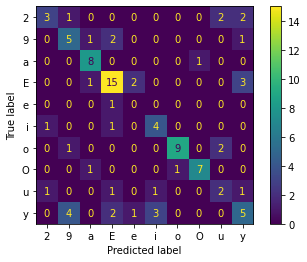

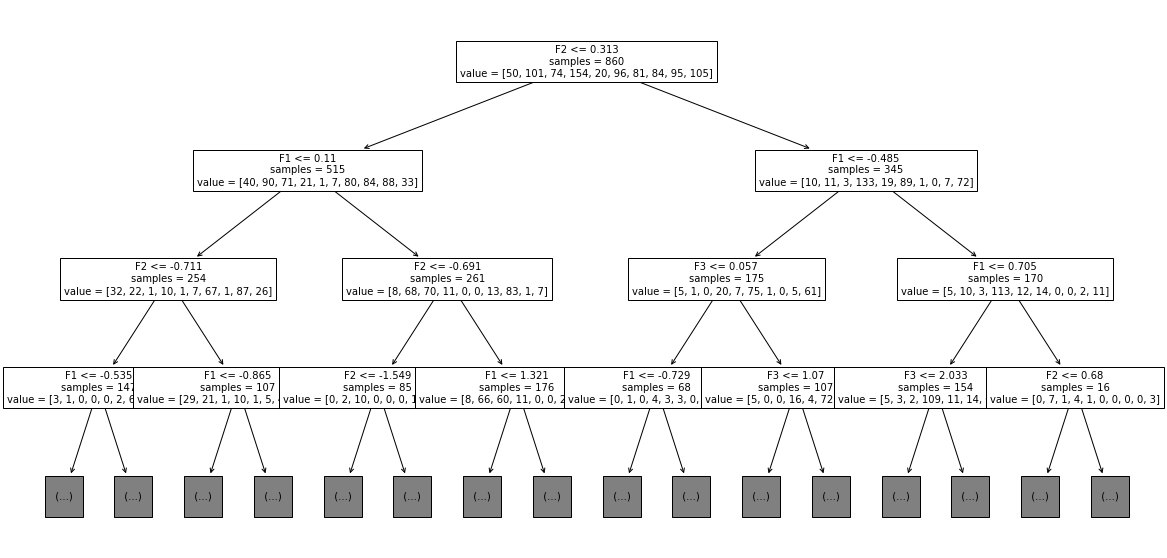

In [13]:
clf = tree.DecisionTreeClassifier(random_state=random_state)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()
ax = plt.figure(figsize=(20, 10)).gca()
tree.plot_tree(clf, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
classifiers.append(('DecisionTree', clf))
plt.show()

## Logistic Regression

              precision    recall  f1-score   support

           2     0.3333    0.1250    0.1818         8
           9     0.5385    0.7778    0.6364         9
           a     0.8750    0.7778    0.8235         9
           E     0.7917    0.9048    0.8444        21
           e     0.0000    0.0000    0.0000         1
           i     0.4444    0.6667    0.5333         6
           o     0.7500    0.7500    0.7500        12
           O     0.7778    0.7778    0.7778         9
           u     0.5000    0.5000    0.5000         6
           y     0.5833    0.4667    0.5185        15

    accuracy                         0.6667        96
   macro avg     0.5594    0.5746    0.5566        96
weighted avg     0.6503    0.6667    0.6490        96



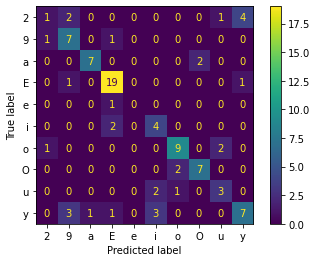

In [14]:
clf = LogisticRegression(random_state=random_state)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Logistic Regression', clf))
plt.show()

## K Neighbors

              precision    recall  f1-score   support

           2     0.4545    0.6250    0.5263         8
           9     0.7000    0.7778    0.7368         9
           a     0.7778    0.7778    0.7778         9
           E     0.8000    0.7619    0.7805        21
           e     0.0000    0.0000    0.0000         1
           i     0.5000    0.6667    0.5714         6
           o     0.8182    0.7500    0.7826        12
           O     0.7143    0.5556    0.6250         9
           u     0.5000    0.6667    0.5714         6
           y     0.8889    0.5333    0.6667        15

    accuracy                         0.6771        96
   macro avg     0.6154    0.6115    0.6039        96
weighted avg     0.7220    0.6771    0.6886        96



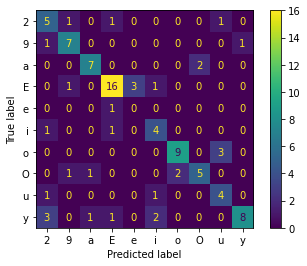

In [15]:
clf = KNeighborsClassifier(n_neighbors=3)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('K Neighbors', clf))
plt.show()

## Multilayer Perceptron

/home/anfasa/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           2     0.6667    0.5000    0.5714         8
           9     0.5714    0.8889    0.6957         9
           a     1.0000    0.8889    0.9412         9
           E     0.8182    0.8571    0.8372        21
           e     0.0000    0.0000    0.0000         1
           i     0.6667    0.6667    0.6667         6
           o     0.8000    0.6667    0.7273        12
           O     0.8750    0.7778    0.8235         9
           u     0.5556    0.8333    0.6667         6
           y     0.7692    0.6667    0.7143        15

    accuracy                         0.7500        96
   macro avg     0.6723    0.6746    0.6644        96
weighted avg     0.7605    0.7500    0.7473        96



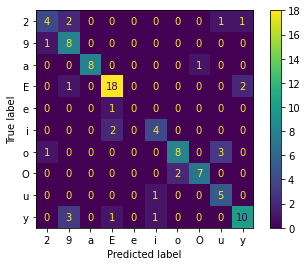

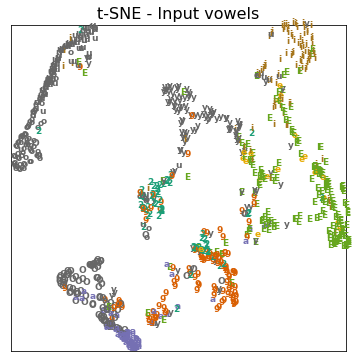

In [16]:
clf = MLPClassifier(random_state=random_state, hidden_layer_sizes=(25, 25), activation='tanh')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Multilayer Perceptron', clf))
plt.show()

activation = formants_tot
hidden_activation = ACTIVATIONS[clf.activation]
for i in range(clf.n_layers_ - 1):
    activation = np.dot(activation, clf.coefs_[i])
    activation += clf.intercepts_[i]
    if i != clf.n_layers_ - 2:
        hidden_activation(activation)
output_activation = ACTIVATIONS[clf.out_activation_]
output_activation(activation)

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(activation)
plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

## Random forests

              precision    recall  f1-score   support

           2     1.0000    0.6250    0.7692         8
           9     0.6364    0.7778    0.7000         9
           a     0.7778    0.7778    0.7778         9
           E     0.8333    0.9524    0.8889        21
           e     0.0000    0.0000    0.0000         1
           i     0.5000    0.6667    0.5714         6
           o     0.9091    0.8333    0.8696        12
           O     0.7778    0.7778    0.7778         9
           u     0.5714    0.6667    0.6154         6
           y     0.8000    0.5333    0.6400        15

    accuracy                         0.7500        96
   macro avg     0.6806    0.6611    0.6610        96
weighted avg     0.7767    0.7500    0.7529        96



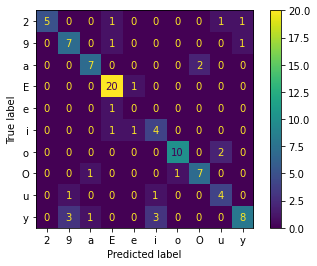

In [17]:
clf = RandomForestClassifier(random_state=random_state, n_estimators=100)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Random forest', clf))
plt.show()

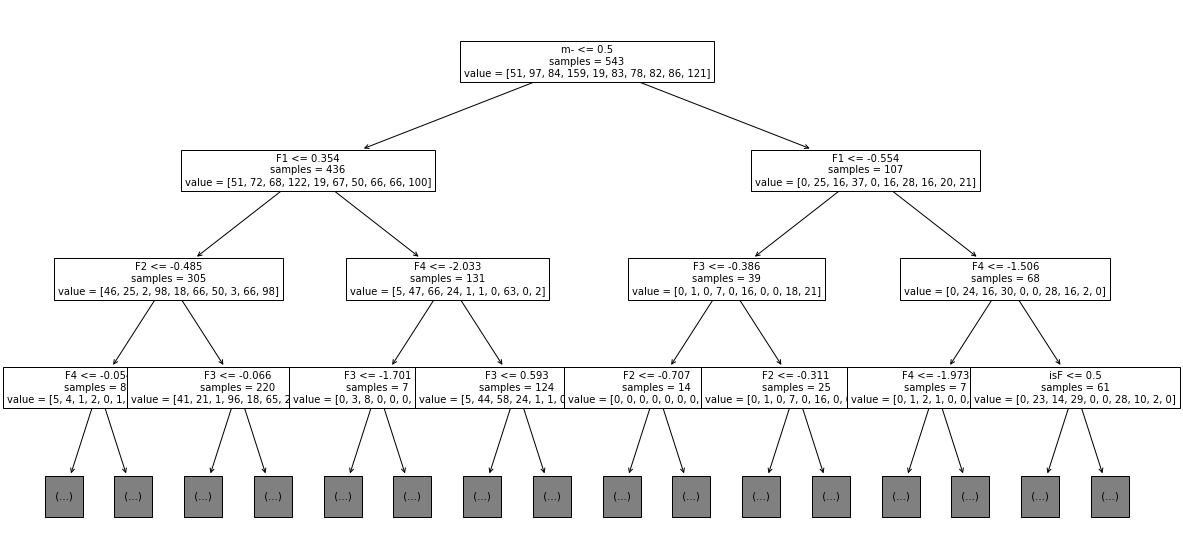

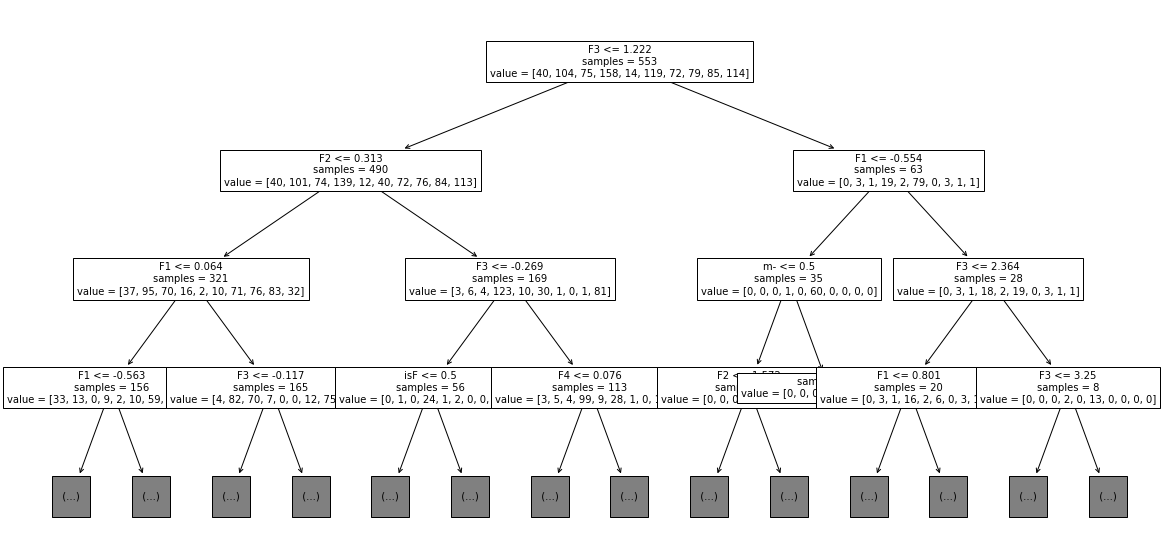

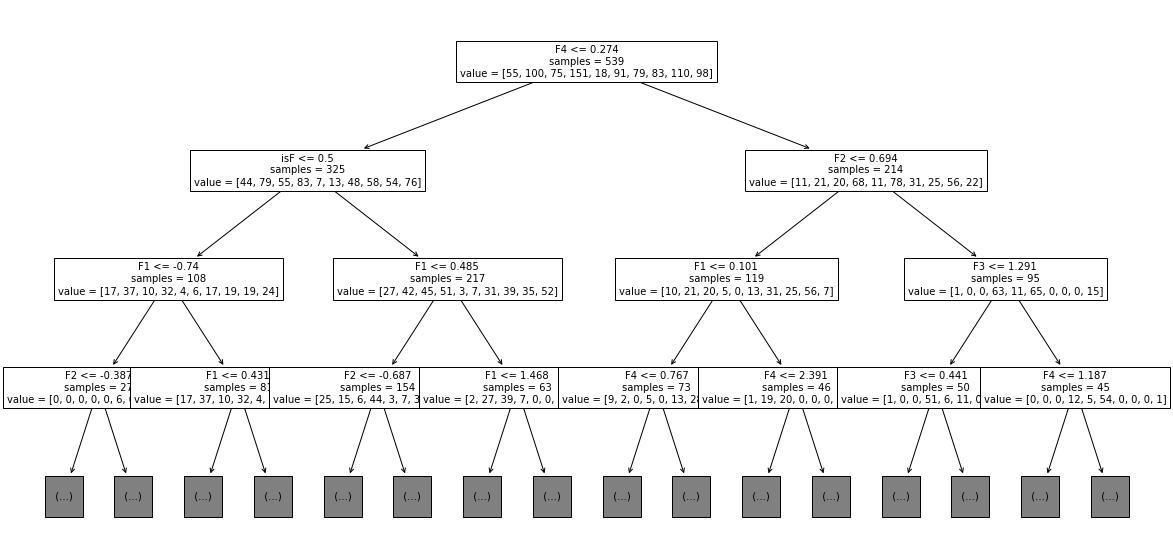

In [18]:
for estimator in clf.estimators_[:3]:
    ax = plt.figure(figsize=(20, 10)).gca()
    tree.plot_tree(estimator, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
    plt.show()

## Bagging

              precision    recall  f1-score   support

           2     0.5000    0.5000    0.5000         8
           9     0.6364    0.7778    0.7000         9
           a     0.9000    1.0000    0.9474         9
           E     0.8000    0.9524    0.8696        21
           e     0.0000    0.0000    0.0000         1
           i     0.5000    0.6667    0.5714         6
           o     0.9000    0.7500    0.8182        12
           O     1.0000    0.7778    0.8750         9
           u     0.5000    0.5000    0.5000         6
           y     0.8889    0.5333    0.6667        15

    accuracy                         0.7396        96
   macro avg     0.6625    0.6458    0.6448        96
weighted avg     0.7683    0.7396    0.7418        96



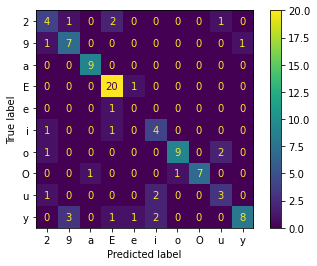

In [19]:
clf = BaggingClassifier(random_state=random_state, n_estimators=10)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Bagging', clf))
plt.show()

## Extra trees

              precision    recall  f1-score   support

           2     0.8333    0.6250    0.7143         8
           9     0.5385    0.7778    0.6364         9
           a     0.8000    0.8889    0.8421         9
           E     0.8636    0.9048    0.8837        21
           e     0.0000    0.0000    0.0000         1
           i     0.6250    0.8333    0.7143         6
           o     0.9091    0.8333    0.8696        12
           O     0.8750    0.7778    0.8235         9
           u     0.5714    0.6667    0.6154         6
           y     0.9000    0.6000    0.7200        15

    accuracy                         0.7708        96
   macro avg     0.6916    0.6908    0.6819        96
weighted avg     0.7949    0.7708    0.7730        96



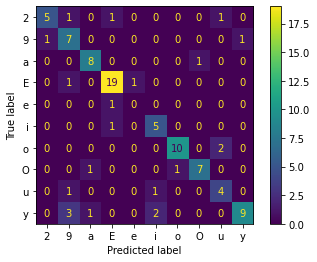

In [20]:
clf = ExtraTreesClassifier(random_state=random_state, n_estimators=500)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Extra trees', clf))
plt.show()

## Stacking

              precision    recall  f1-score   support

           2     0.8000    0.5000    0.6154         8
           9     0.7000    0.7778    0.7368         9
           a     0.8000    0.8889    0.8421         9
           E     0.7826    0.8571    0.8182        21
           e     0.0000    0.0000    0.0000         1
           i     0.4444    0.6667    0.5333         6
           o     0.9091    0.8333    0.8696        12
           O     0.8750    0.7778    0.8235         9
           u     0.5000    0.6667    0.5714         6
           y     0.7000    0.4667    0.5600        15

    accuracy                         0.7188        96
   macro avg     0.6511    0.6435    0.6370        96
weighted avg     0.7426    0.7188    0.7207        96



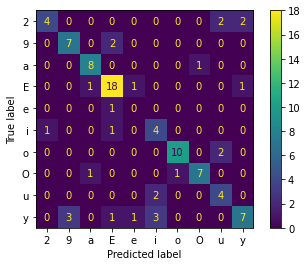

In [21]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(classifiers, cv='prefit')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()